In [1]:
#importing libraries
import os
import sys 
import cv2 as cv
import numpy as np
import plotly.io as pio
import ipywidgets as widget
import plotly.graph_objs as go
import matplotlib.pyplot as plt


from PIL import Image
from skimage import color
from plotly import subplots
from random import randrange
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from ipywidgets import interact, interactive, fixed, interact_manual

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,confusion_matrix

import cv2 as cv
import math

import seaborn as sns
import matplotlib.pyplot as plt

# #setting the rederer as colab
# pio.renderers.default = "colab"

In [2]:
# path to images

def input_images(path):

  X = []
  X_flat = []

  size = 64

  # iterate through images
  for img in os.listdir(path):

      # read and grayscale image
      img_array = cv.imread(os.path.join(path, img), cv.IMREAD_GRAYSCALE)
      
      # form matrix of an image
      img_pil = Image.fromarray(img_array)

      # resize image
      img_64x64 = np.array(img_pil.resize((size, size)))

      X.append(img_64x64)

      # flatten the image
      img_array = img_64x64.flatten()

      X_flat.append(img_array)

  # convert to numpy array
  X_flat = np.asarray(X_flat)

  # images as columns
  X_flat = X_flat.T

  return X, X_flat

In [3]:
path_class_yes = "brain_tumor_dataset/yes/"
path_class_no = "brain_tumor_dataset/no/"


In [4]:
def filter_gaussian(img, kernel_size=(3, 3)):
  img_gaussian = cv.GaussianBlur(img, (3, 3), 0)
  return img_gaussian

In [5]:
def detector_sobel_x_y(img):
  sobel_x_y = cv.Sobel(src=img, ddepth=cv.CV_64F, dx=1, dy=1, ksize=5)
  return sobel_x_y

In [6]:
def standardize(X):
    """
    The standardize function standardizes the input matrix X 
    by subtracting the mean of each column and dividing by the standard deviation.
    
    Returns the standardized matrix X_stand, mean (mu) 
    and standard deviation (std) values used in the standardization process.
    """

    # calcualte the mean of each respective column   
    mu = np.mean(X, axis = 0)

    # calcualte the standard deviation of each column
    std = np.std(X, axis = 0)  
    
    # substract the mean from X
    X = X - mu   
    
    # handle zero std case (cannot divide by zero)
    std_filled = std.copy()
    std_filled[std == 0] = 1
    
    #calculate standardized X
    X_stand = (X - mu) / std_filled
    
    return X_stand, mu, std

In [7]:
def eigen(X):
    """
    The eigen function finds the eigenvalues and eigenvectors of input matrix X 
    using build-in function of numpy.
    
    Returns eigenvalues (EV) and eigenvectors (EVc) of input matrix X, sorted in
    descending order.
    """
  
    #calculate the eigen values and eigen vectors
    EV, EVc = np.linalg.eigh(X)  

    # order of eigenvalues (bigger to smaller)
    order = np.argsort(-EV)

    # order the EV's
    EV = EV[order]

    # construct matrix of eigenvectors
    EVc = EVc[:, order]
    
    return EV, EVc

In [8]:

def PCA(X, num_components):

    # calculate the data covariance matrix S
    # S = 1 / (len(X) - 1) * np.matmul(X, X.T)
    S = np.cov(X)
    
    # eigenvalues and corresponding eigenvectors for S
    eig_vals, eig_vecs = eigen(S)
    
    # select eigen vectors
    U = eig_vecs[:, range(num_components)]
    
    # find the projection_matrix which projects our input data onto the vector space spanned by the eigenvectors
    P = np.matmul(U, U.T)
    
    return P

Accuracy of KNN is %81.95488721804512


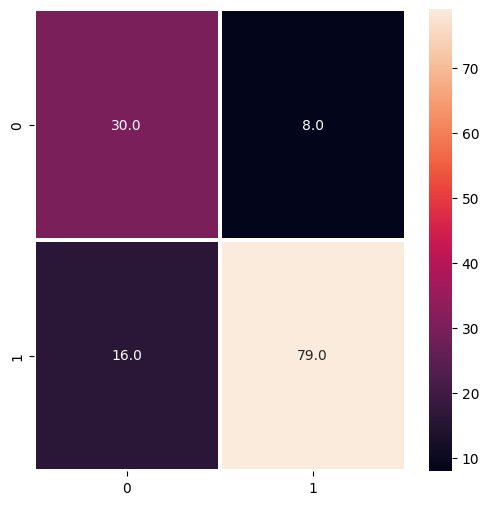

In [9]:
def image_preprocessing(path_class_yes, path_class_no):

  X_yes, X_flat_yes = input_images(path_class_yes)
  X_no, X_flat_no = input_images(path_class_no)

  X_flat_yes = X_flat_yes.T
  X_flat_no = X_flat_no.T

  X_train_yes = X_flat_yes[:60].T
  X_test_yes = X_flat_yes[60:].T
  X_train_no = X_flat_no[:60].T
  X_test_no = X_flat_no[60:].T

  # combine classes
  X_flat_yes_no_train = np.concatenate((X_train_yes.T, X_train_no.T)).T
  X_flat_yes_no_test = np.concatenate((X_test_yes.T, X_test_no.T)).T

  y_train = np.concatenate((np.ones(60), np.zeros(60)))
  y_test = np.concatenate((np.ones(155-60), np.zeros(98-60))) 

  # apply filters
  gaussian_filter_applied = filter_gaussian(X_flat_yes_no_train)
  gaussian_filter_applied_test = filter_gaussian(X_flat_yes_no_test)

  # apply edge detectors
  sobel_edge_detector_applies = detector_sobel_x_y(gaussian_filter_applied)
  sobel_edge_detector_applies_test = detector_sobel_x_y(gaussian_filter_applied_test)

  # PCA part
  X_train, mu_train, std_train = standardize(sobel_edge_detector_applies)
  X_test, mu_test, std_test = standardize(sobel_edge_detector_applies_test)

  def pca_apply(X_t, X_f):

    loss = []

    reconstructions = []

    max_components = len(np.array(X_f).T)

    for num_component in range(1, max_components + 1):
 
        projection = PCA(X_t.T, num_component)

        y_transform = np.matmul(X_t, projection)

        error = mse(y_transform, X_f)

        reconstructions.append(y_transform)

        loss.append((num_component, error))

    #unstandardizing the reconstructed images
    reconstructions = np.asarray(reconstructions)
    loss = np.asarray(loss)

    yes_reconst = reconstructions[100, : , :]
    yes_reconst = yes_reconst
  
    return yes_reconst

  processed_train = pca_apply(X_train, X_flat_yes_no_train)
  processed_test = pca_apply(X_test, X_flat_yes_no_test)

  clf = KNeighborsClassifier()
    
  clf.fit(processed_train.T,y_train)

  y_pred = clf.predict(processed_test.T)
  
  print("Accuracy of KNN is %{}".format(accuracy_score(y_pred=y_pred,y_true=y_test)*100))
    
  confmatrix = confusion_matrix(y_pred=y_pred,y_true=y_test)
    
  plt.subplots(figsize=(6,6))
  sns.heatmap(confmatrix,annot=True,fmt=".1f",linewidths=1.5)

image_preprocessing(path_class_yes, path_class_no)
